# Road Lane Detection 

In [1]:
# Import required libraries/dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os  # Add this import

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

In [2]:
# Training path
train_path = '/kaggle/input/preprocessed-1/tusimple_preprocessed/training'

In [3]:
# Define TensorBoard callback
tensorboard_callback = keras.callbacks.TensorBoard(log_dir='/kaggle/working/tensorboard_logs_1', histogram_freq=1)

# Define ModelCheckpoint callback
model_checkpoint_callback =  keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")


# Combine all callbacks
callbacks = [tensorboard_callback, model_checkpoint_callback]

In [4]:
# Create a generator and get the images from the directory
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)


Found 7252 images belonging to 2 classes.


In [5]:
'''
Assign the images in 'images_set' to two seperate arrays:
assign the road images to 'X' and the ground truth masks to 'Y'
'''
num_images = 7252 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0: 
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

# convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70
Batch 80
Batch 90
Batch 100
Batch 110


In [6]:
# shuffle the dataset
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=100)

In [7]:
# becacuse of lack of resources like RAM, we only get 2000 training samples
X = np.array(X[:2000])
Y = np.array(Y[:2000])

In [8]:
display(X.shape)
display(Y.shape)

(2000, 256, 320, 3)

(2000, 256, 320)

In [9]:
# Normalize and reshape the mask set (Y)
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

In [10]:
Y.min(), Y.max()

(0, 1)

In [11]:
# Split the datset into train and val sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

In [12]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)

Shape of X_train: (1400, 256, 320, 3)
Shape of X_val: (600, 256, 320, 3)
Shape of Y_train: (1400, 256, 320, 1)
Shape of Y_val: (600, 256, 320, 1)


In [13]:
# free the RAM from undesired clutters
import gc
del X, Y, images_set
gc.collect()

0

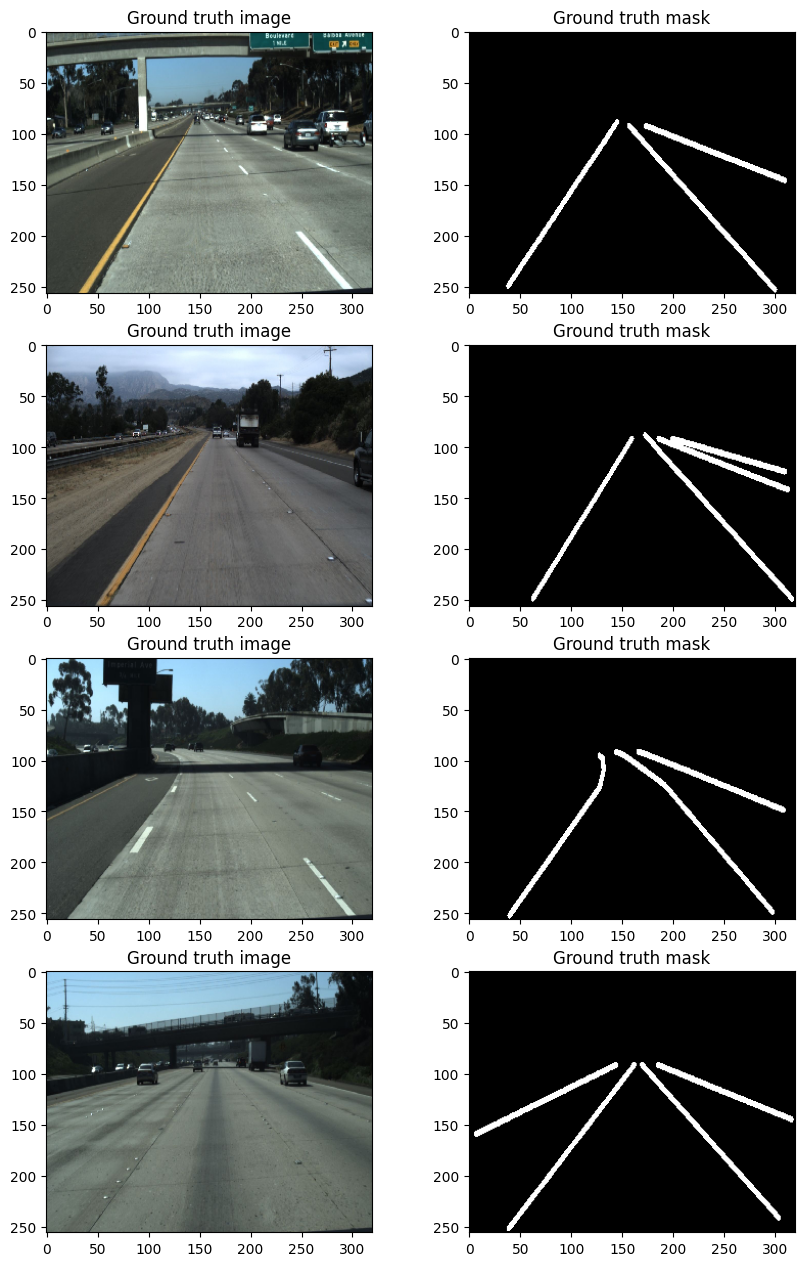

In [14]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Ground truth mask')
    index += 2

Model 1: Simple Autoencoder

In [15]:
import numpy as np
import cv2
from keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D, UpSampling2D
from keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Define the Simple Autoencoder
def simple_autoencoder(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = MaxPooling2D((2, 2), padding='same')(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = MaxPooling2D((2, 2), padding='same')(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv2)
    conv3 = MaxPooling2D((2, 2), padding='same')(conv3)

    # Decoder
    up1 = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2, 2))(up1)
    up2 = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(up2)
    up3 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2, 2))(up3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(up3)

    return Model(inputs, outputs)

# Assuming X_train, Y_train, X_val, Y_val are defined and properly loaded
# Initialize model
input_shape = (256, 320, 3)
simple_autoencoder_model = simple_autoencoder(input_shape)

# Compile the model
simple_autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Simple Autoencoder
history_simple = simple_autoencoder_model.fit(
    X_train, Y_train,
    epochs=3,
    batch_size=16,
    validation_data=(X_val, Y_val)
)
# Make Predictions
Y_pred = simple_autoencoder_model.predict(X_val)

# Convert predictions to binary (thresholding)
Y_pred_binary = (Y_pred > 0.5).astype(np.uint8)

# Reshape Y_val for classification report
Y_val_reshaped = Y_val.reshape(-1, 256 * 320)
Y_pred_binary_reshaped = Y_pred_binary.reshape(-1, 256 * 320)

# Generate Classification Report
print("Classification Report:")
print(classification_report(Y_val_reshaped.flatten(), Y_pred_binary_reshaped.flatten()))



Epoch 1/3
88/88 [==============================] - 862s 10s/step - loss: 0.3046 - accuracy: 0.9482 - val_loss: 0.1242 - val_accuracy: 0.9616
Epoch 2/3
88/88 [==============================] - 845s 10s/step - loss: 0.1081 - accuracy: 0.9639 - val_loss: 0.0997 - val_accuracy: 0.9661
Epoch 3/3
19/19 [==============================] - 99s 5s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98  47051196
           1       0.75      0.38      0.50   2100804

    accuracy                           0.97  49152000
   macro avg       0.86      0.69      0.74  49152000
weighted avg       0.96      0.97      0.96  49152000



Model 2: simple CNN_based autoencoder

In [16]:
import numpy as np
import cv2
from keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D, UpSampling2D
from keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Define the Simple CNN-based Autoencoder
def simple_cnn_autoencoder(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = MaxPooling2D((2, 2), padding='same')(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = MaxPooling2D((2, 2), padding='same')(conv2)
    
    # Decoder
    up1 = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(conv2)
    up1 = UpSampling2D((2, 2))(up1)
    up2 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(up2)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(up2)

    return Model(inputs, outputs)

# Initialize model
input_shape = (256, 320, 3)
cnn_autoencoder_model = simple_cnn_autoencoder(input_shape)
cnn_autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Simple CNN-based Autoencoder
history_cnn = cnn_autoencoder_model.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_val, Y_val)
)

# Model summary
cnn_autoencoder_model.summary()

# Make Predictions
Y_pred_cnn = cnn_autoencoder_model.predict(X_val)
Y_pred_cnn_binary = (Y_pred_cnn > 0.5).astype(np.uint8)

# Reshape Y_val for classification report
Y_val_reshaped = Y_val.reshape(-1, 256 * 320)
Y_pred_cnn_binary_reshaped = Y_pred_cnn_binary.reshape(-1, 256 * 320)

# Generate Classification Report
print("CNN-based Autoencoder Classification Report:")
print(classification_report(Y_val_reshaped.flatten(), Y_pred_cnn_binary_reshaped.flatten()))


Epoch 1/10
88/88 [==============================] - 546s 6s/step - loss: 0.8358 - accuracy: 0.9368 - val_loss: 0.1714 - val_accuracy: 0.9581
Epoch 2/10
88/88 [==============================] - 572s 7s/step - loss: 0.1531 - accuracy: 0.9603 - val_loss: 0.1314 - val_accuracy: 0.9623
Epoch 3/10
88/88 [==============================] - 563s 6s/step - loss: 0.1271 - accuracy: 0.9625 - val_loss: 0.1154 - val_accuracy: 0.9635
Epoch 4/10
88/88 [==============================] - 565s 6s/step - loss: 0.1147 - accuracy: 0.9637 - val_loss: 0.1104 - val_accuracy: 0.9647
Epoch 5/10
88/88 [==============================] - 560s 6s/step - loss: 0.1084 - accuracy: 0.9647 - val_loss: 0.1016 - val_accuracy: 0.9655
Epoch 6/10
88/88 [==============================] - 569s 6s/step - loss: 0.1018 - accuracy: 0.9657 - val_loss: 0.0973 - val_accuracy: 0.9664
Epoch 7/10
88/88 [==============================] - 560s 6s/step - loss: 0.0995 - accuracy: 0.9662 - val_loss: 0.0960 - val_accuracy: 0.9672
Epoch 8/10
88

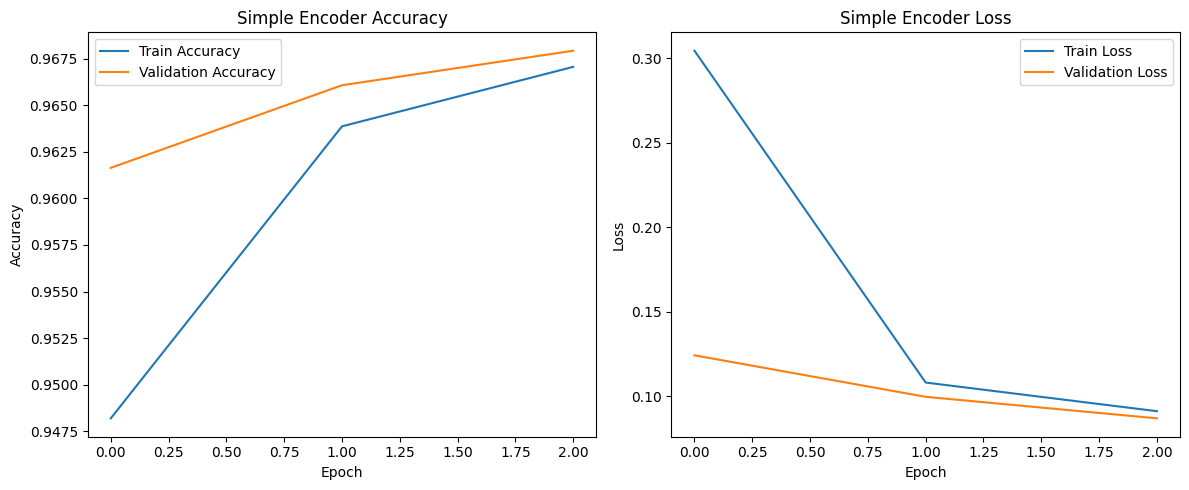

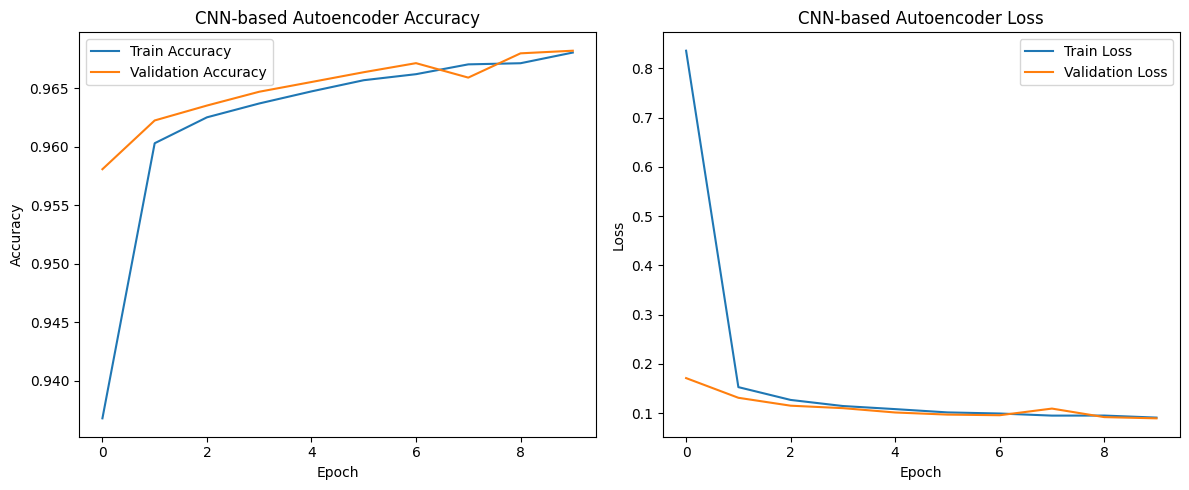

In [17]:
import matplotlib.pyplot as plt

# Function to plot metrics
def plot_metrics(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
# Plot metrics for simple encoder Model
plot_metrics(history_simple, "Simple Encoder")
# Plot metrics for Simple CNN-based Autoencoder
plot_metrics(history_cnn, "CNN-based Autoencoder")



In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU

def evaluate_model(model, X_val, Y_val):
    # Make Predictions
    preds = model.predict(X_val)

    # Convert predictions to binary (thresholding)
    preds_binary = (preds > 0.5).astype(np.uint8)

    # Reshape for evaluation
    Y_val_flat = Y_val.reshape(-1, 256 * 320)
    preds_flat = preds_binary.reshape(-1, 256 * 320)

    # Calculate metrics
    accuracy_value = accuracy_score(Y_val_flat.flatten(), preds_flat.flatten())
    precision_value = precision_score(Y_val_flat.flatten(), preds_flat.flatten())
    recall_value = recall_score(Y_val_flat.flatten(), preds_flat.flatten())
    f1_score_value = f1_score(Y_val_flat.flatten(), preds_flat.flatten())

    # IoU
    iou = MeanIoU(num_classes=2)  # Assuming binary segmentation
    iou.update_state(Y_val, preds_binary)
    iou_value = iou.result().numpy()

    # Print results
    print("Accuracy:", accuracy_value)
    print("Precision:", precision_value)
    print("Recall:", recall_value)
    print('F1 Score:', f1_score_value)
    print('IoU:', iou_value)

# Assuming you have already trained your models
# Evaluate the Simple Autoencoder
print("Evaluating Simple Autoencoder...")
evaluate_model(simple_autoencoder_model, X_val, Y_val)

# Evaluate the CNN-based Autoencoder
print("Evaluating CNN-based Autoencoder...")
evaluate_model(cnn_autoencoder_model, X_val, Y_val)


Evaluating Simple Autoencoder...
19/19 [==============================] - 101s 5s/step
Accuracy: 0.9679370930989584
Precision: 0.7478532057409037
Recall: 0.3769118870679987
F1 Score: 0.5012153467916112
IoU: 0.6242731
Evaluating CNN-based Autoencoder...
19/19 [==============================] - 66s 3s/step
Accuracy: 0.9682215169270834
Precision: 0.7038939140753657
Recall: 0.44272859343375204
F1 Score: 0.5435685423307234
IoU: 0.644024
